# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096-iap17/blob/master/lecture1/Boxes-and-registers.ipynb.)

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [14]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Array{Float64,1}:
 0.5664614172508322   
 0.497584339142527    
 0.8320038468026796   
 0.0016277060602898352
 0.25073547436991594  
 0.5066209260877634   
 0.745994708400574    
 0.38139825917266545  
 0.07629532038221987  
 0.5109200682548658   
 0.5037260022774557   
 0.058889960103660544 
 0.2868784519260281   
 ⋮                    
 0.22358814764817048  
 0.3549792609917679   
 0.08740499538551671  
 0.07464740093630073  
 0.7231606067617913   
 0.4434681289809608   
 0.797675102722091    
 0.7958158781949154   
 0.2533878348411496   
 0.1652460221222427   
 0.5512008953873238   
 0.7424917530739601   

In [15]:
sum(a)

5.00012018027259e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

Julia has a `BenchmarkTools.jl` package for easy and accurate benchmarking:

In [16]:
#Pkg.add("BenchmarkTools")

In [17]:
using BenchmarkTools

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [18]:
using Libdl

In [19]:
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc  -fPIC -O3 -ffast-math -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [20]:
c_sum(a)

5.000120180272702e6

In [21]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [22]:
≈  # alias for the `isapprox` function

isapprox (generic function with 8 methods)

In [23]:
?isapprox

search: isapprox



```
isapprox(x, y; rtol::Real=atol>0 ? 0 : √eps, atol::Real=0, nans::Bool=false, norm::Function)
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

`x` and `y` may also be arrays of numbers, in which case `norm` defaults to `vecnorm` but may be changed by passing a `norm::Function` keyword argument. (For numbers, `norm` is the same thing as `abs`.) When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```


We can now benchmark the C code directly from Julia:

In [24]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     6.223 ms (0.00% GC)
  median time:      6.362 ms (0.00% GC)
  mean time:        6.831 ms (0.00% GC)
  maximum time:     11.606 ms (0.00% GC)
  --------------
  samples:          732
  evals/sample:     1

In [25]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 6.223214 msec


In [53]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any,Any} with 1 entry:
  "C" => 6.22321

In [54]:
using Plots
gr()

Plots.GRBackend()

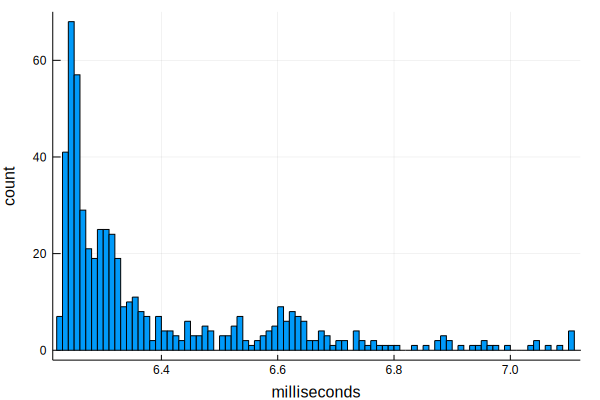

In [55]:
using Statistics

t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. Python's built in `sum`

The `PyCall` package provides a Julia interface to Python:

In [56]:
]add PyCall

 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


In [57]:
using PyCall

In [58]:
# Call a low-level PyCall function to get a Python list, because
# by default PyCall will convert to a NumPy array instead (we benchmark NumPy below):

apy_list = PyCall.array2py(a, 1, 1)

# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [59]:
pysum(a)

5.000120180271203e6

In [60]:
pysum(a) ≈ sum(a)

true

In [61]:
py_list_bench = @benchmark $pysum($apy_list)

BenchmarkTools.Trial: 
  memory estimate:  48 bytes
  allocs estimate:  3
  --------------
  minimum time:     37.163 ms (0.00% GC)
  median time:      39.037 ms (0.00% GC)
  mean time:        41.951 ms (0.00% GC)
  maximum time:     65.504 ms (0.00% GC)
  --------------
  samples:          120
  evals/sample:     1

In [62]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any,Any} with 2 entries:
  "C"               => 6.22321
  "Python built-in" => 37.1634

# 3. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [63]:
using Conda 
#Conda.add("numpy")

ArgumentError: ArgumentError: Package Conda not found in current path:
- Run `Pkg.add("Conda")` to install the Conda package.


In [64]:
numpy_sum = pyimport("numpy")["sum"]
apy_numpy = PyObject(a) # converts to a numpy array by default

py_numpy_bench = @benchmark $numpy_sum($apy_numpy)

BenchmarkTools.Trial: 
  memory estimate:  48 bytes
  allocs estimate:  3
  --------------
  minimum time:     3.982 ms (0.00% GC)
  median time:      4.604 ms (0.00% GC)
  mean time:        4.998 ms (0.00% GC)
  maximum time:     10.750 ms (0.00% GC)
  --------------
  samples:          999
  evals/sample:     1

In [65]:
numpy_sum(apy_list) # python thing

5.000120180272588e6

In [66]:
numpy_sum(apy_list) ≈ sum(a)

true

In [67]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 3 entries:
  "C"               => 6.22321
  "Python numpy"    => 3.98233
  "Python built-in" => 37.1634

# 4. Python, hand-written

In [68]:
py"""
def py_sum(a):
    s = 0.0
    for x in a:
        s = s + x
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7f943409dd90>

In [69]:
py_hand = @benchmark $sum_py($apy_list)

BenchmarkTools.Trial: 
  memory estimate:  48 bytes
  allocs estimate:  3
  --------------
  minimum time:     220.201 ms (0.00% GC)
  median time:      226.969 ms (0.00% GC)
  mean time:        230.465 ms (0.00% GC)
  maximum time:     249.872 ms (0.00% GC)
  --------------
  samples:          22
  evals/sample:     1

In [70]:
sum_py(apy_list)

5.000120180271203e6

In [71]:
sum_py(apy_list) ≈ sum(a)

true

In [72]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C"                   => 6.22321
  "Python numpy"        => 3.98233
  "Python hand-written" => 220.201
  "Python built-in"     => 37.1634

# 5. Julia (built-in) 

## Written directly in Julia, not in C!

In [73]:
@which sum(a)

sum(a::AbstractArray) in Base at reducedim.jl:645

In [74]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.676 ms (0.00% GC)
  median time:      5.176 ms (0.00% GC)
  mean time:        5.518 ms (0.00% GC)
  maximum time:     15.141 ms (0.00% GC)
  --------------
  samples:          905
  evals/sample:     1

In [75]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any,Any} with 5 entries:
  "C"                   => 6.22321
  "Python numpy"        => 3.98233
  "Python hand-written" => 220.201
  "Python built-in"     => 37.1634
  "Julia built-in"      => 4.67592

# 6. Julia (hand-written)

In [87]:
function mysum(A)   
    s = 0.0  # s = zero(eltype(A))
    # @inbounds @simd for a in A
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [85]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.897 ms (0.00% GC)
  median time:      5.971 ms (0.00% GC)
  mean time:        6.059 ms (0.00% GC)
  maximum time:     9.425 ms (0.00% GC)
  --------------
  samples:          824
  evals/sample:     1

In [88]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any,Any} with 6 entries:
  "C"                   => 6.22321
  "Python numpy"        => 3.98233
  "Julia hand-written"  => 4.89719
  "Python hand-written" => 220.201
  "Python built-in"     => 37.1634
  "Julia built-in"      => 4.67592

# Summary

In [89]:
for (key, value) in sort(collect(d))
    println(rpad(key, 20, "."), lpad(round(value, digits=1), 8, "."))
end

C........................6.2
Julia built-in...........4.7
Julia hand-written.......4.9
Python built-in.........37.2
Python hand-written....220.2
Python numpy.............4.0


In [90]:
for (key, value) in sort(collect(d), by=x->x[2])
    println(rpad(key, 20, "."), lpad(round(value, digits=2), 10, "."))
end

Python numpy..............3.98
Julia built-in............4.68
Julia hand-written.........4.9
C.........................6.22
Python built-in..........37.16
Python hand-written......220.2
